In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Loading Dataset

In [2]:
df = pd.read_csv('tc20171021.csv', error_bad_lines=False, warn_bad_lines=False)
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (1216250, 9)


,Id,Price,Year,Mileage,City,State,Vin,Make,Model
0,1,16472,2015,18681,Jefferson City,MO,KL4CJBSBXFB267643,Buick,EncoreConvenience
1,2,15749,2015,27592,Highland,IN,KL4CJASB5FB245057,Buick,EncoreFWD
2,3,16998,2015,13650,Boone,NC,KL4CJCSB0FB264921,Buick,EncoreLeather
3,4,15777,2015,25195,New Orleans,LA,KL4CJASB4FB217542,Buick,EncoreFWD
4,5,16784,2015,22800,Las Vegas,NV,KL4CJBSB3FB166881,Buick,EncoreConvenience


### Preprocessing

#### Check for null values

In [3]:
df.isna().sum()

Id         0
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

#### Change all text data to lower case

In [4]:
str_columns = df.select_dtypes(include=['object']).columns
for col in str_columns:
    df[col] = df[col].str.lower()

df.head()

,Id,Price,Year,Mileage,City,State,Vin,Make,Model
0,1,16472,2015,18681,jefferson city,mo,kl4cjbsbxfb267643,buick,encoreconvenience
1,2,15749,2015,27592,highland,in,kl4cjasb5fb245057,buick,encorefwd
2,3,16998,2015,13650,boone,nc,kl4cjcsb0fb264921,buick,encoreleather
3,4,15777,2015,25195,new orleans,la,kl4cjasb4fb217542,buick,encorefwd
4,5,16784,2015,22800,las vegas,nv,kl4cjbsb3fb166881,buick,encoreconvenience


#### Simple data profiling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff412581d0>,
      dtype=object)

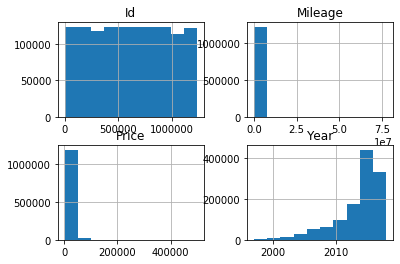

In [5]:
df.hist()

In [6]:
df.describe()

,Id,Price,Year,Mileage
count,1216250.000,1216250.000,1216250.000,1216250.000
mean,613281.414,20968.871,2013.307,52908.102
std,354657.101,13159.402,3.442,81927.749
min,1.000,1500.000,1997.000,5.000
25%,308112.250,12994.000,2012.000,23962.000
50%,613491.500,17995.000,2014.000,40534.000
75%,917553.750,26414.000,2016.000,72725.000
max,1233042.000,499500.000,2018.000,77587763.000


#### Box Plot

Text(0.5, 1.0, 'Price Boxplot')

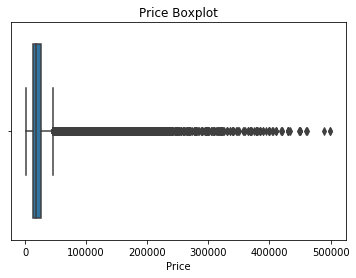

In [7]:
sns.boxplot(x=df['Price']).set_title("Price Boxplot")

Text(0.5, 1.0, 'Mileage Boxplot')

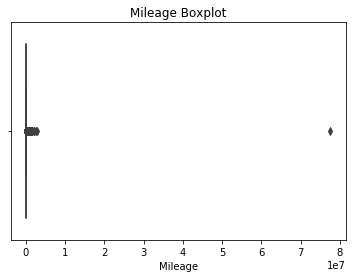

In [8]:
sns.boxplot(x=df['Mileage']).set_title("Mileage Boxplot")

#### Removing Outliers

Removing top and bottom 2.5% of Mileage and Price data

(1094626, 9)

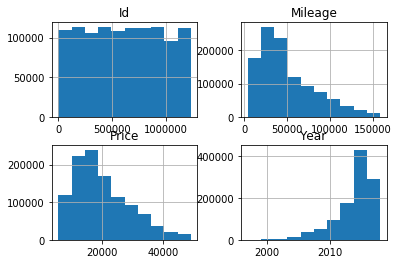

In [9]:
rows = df.shape[0]
rows_10_percent = int(rows * 0.025)


df = df.sort_values(by=['Mileage'], ascending=False)[rows_10_percent:]
df = df[:-rows_10_percent]
df = df.sort_values(by=['Price'], ascending=False)
df = df[rows_10_percent:]
df = df[:-rows_10_percent]

df.hist()
df.shape

#### Boxplot After Outliers Removal

Text(0.5, 1.0, 'Price Boxplot')

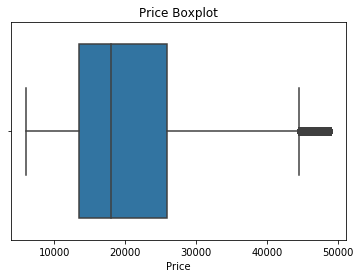

In [10]:
sns.boxplot(x=df['Price']).set_title("Price Boxplot")

Text(0.5, 1.0, 'Price Boxplot')

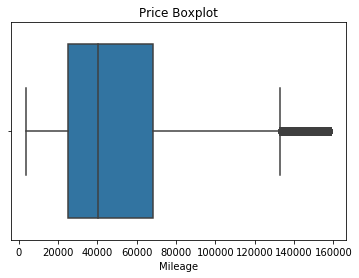

In [11]:
sns.boxplot(x=df['Mileage']).set_title("Price Boxplot")

### Exploratory Data Analysis

#### Price Distribution

Price distribution


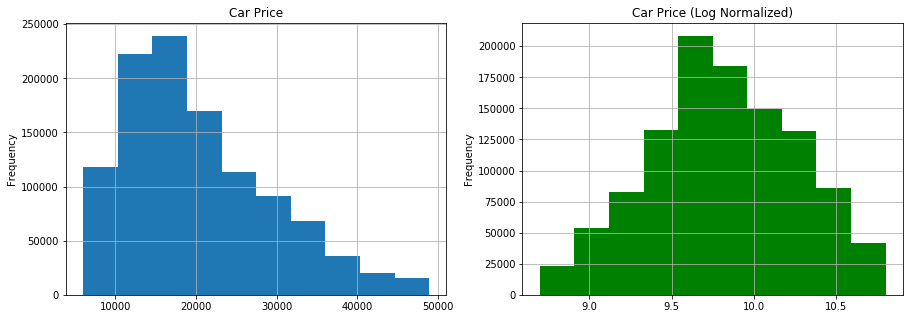

In [12]:
print('Price distribution')
plt.subplot(1, 2, 1)
df.Price.plot(kind='hist', figsize = (15,5), title = 'Car Price', grid=True)
plt.subplot(1, 2, 2)
np.log(df.Price).plot(kind='hist', title='Car Price (Log Normalized)', grid=True, color='green')

#### Average Car Price per Brand & Type

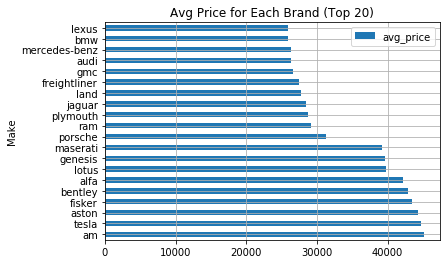

In [13]:
df.groupby('Make').agg(avg_price=('Price', 'mean')).sort_values(by='avg_price', ascending=False)[:20]\
.plot(kind='barh', grid=True)
plt.title('Avg Price for Each Brand (Top 20)')
plt.show()

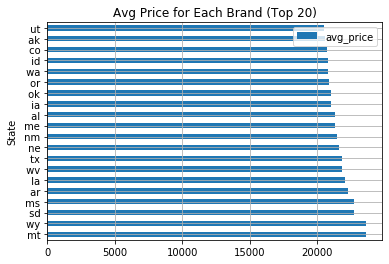

In [14]:
df.groupby('State').agg(avg_price=('Price', 'mean')).sort_values(by='avg_price', ascending=False)[:20]\
.plot(kind='barh', grid=True)
plt.title('Avg Price for Each Brand (Top 20)')
plt.show()

#### Car Price vs Mileage

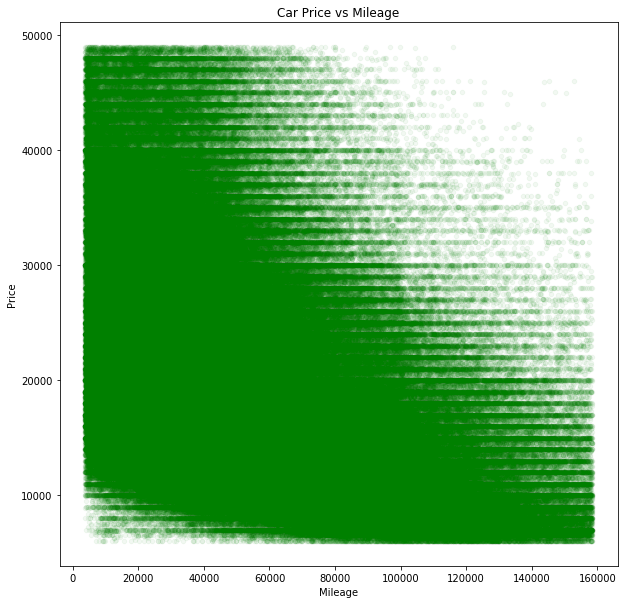

In [15]:
df.plot(kind='scatter', x = 'Mileage', y = 'Price', color='green', figsize=(10,10), alpha=0.05)
plt.title('Car Price vs Mileage')
plt.show()

#### Vehicle Model Year vs Price

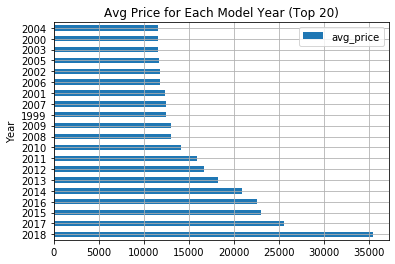

In [16]:
df.groupby('Year').agg(avg_price=('Price', 'mean')).sort_values(by='avg_price', ascending=False)[:20]\
.plot(kind='barh', grid=True)
plt.title('Avg Price for Each Model Year (Top 20)')
plt.show()

In [17]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Id,Price,Year,Mileage
Id,1,-0.0225251,0.042121,-0.0301287
Price,-0.0225251,1,0.40963,-0.432317
Year,0.042121,0.40963,1,-0.736671
Mileage,-0.0301287,-0.432317,-0.736671,1


#### EDA: Key takeaways

From this exploratory data analysis, here are some key take aways:
1. Model year is possitively correlated with used vehicle price
2. Mileage (odometer) is negatively correlated with used vehicle price
3. Vehicle maker (manufacturer) has impact to the used vehicle price
4. State attribute does not have a strong impact
5. Vehicle model and city is ignored since it has a very high cardinality

We will then use three features (model year, mileage, manufacturer) to build our model

### Building Models

#### Select Relevant Feature and Encode Categorical Variable

In [18]:
from sklearn.preprocessing import LabelEncoder

features = ['Price', 'Year', 'Mileage', 'Make']
df_filtered = df[features]

lb_make = LabelEncoder()
df_filtered['Make'] = lb_make.fit_transform(df['Make'])
df_filtered.head()

/home/ibam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Price,Year,Mileage,Make
9566,48945,2015,96680,18
150512,48945,2017,17515,6
20945,48944,2015,53268,14
192737,48944,2016,9141,4
702691,48944,2016,31315,14


#### Splitting Data

In [45]:
from sklearn.model_selection import train_test_split

X = df_filtered[df_filtered.columns[1:4]]
y = df_filtered[['Price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
n = len(X.columns)

#### Training and Evaluating Models: Linear Regression using Tensorflow

In [40]:
import tensorflow as tf

tf.reset_default_graph()

X_train_transposed = X_train.transpose()
y_train_transposed = y_train.transpose()

x = tf.placeholder(tf.float32, shape=(n, None))
y = tf.placeholder(tf.float32, shape=(1, None))

A = tf.get_variable("A", shape=(1, n))
b = tf.get_variable("b", shape=())

y_predicted = tf.matmul(A, x) + b
L = tf.reduce_sum((y_predicted - y)**2)

# Define optimizer object
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(L)

# Create a session and initialize variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# Main optimization loop
for t in range(5000):
    _, current_loss, current_A, current_b = session.run([optimizer, L, A, b], feed_dict={
        x: X_train_transposed,
        y: y_train_transposed
    })
    
    if ((t + 1) % 100 == 0):
        print("t = %g, loss = %g, A = %s, b = %g" % (t, current_loss, str(current_A), current_b))

t = 99, loss = 1.27809e+14, A = [[3.626876   0.15189081 4.2599964 ]], b = 5.41099
t = 199, loss = 7.9669e+13, A = [[7.0524077  0.04699029 7.423275  ]], b = 8.82989
t = 299, loss = 5.77575e+13, A = [[ 9.689089   -0.02890122  9.588348  ]], b = 11.4613
t = 399, loss = 5.07427e+13, A = [[11.326807  -0.0759105 10.532656 ]], b = 13.0952
t = 499, loss = 4.90714e+13, A = [[12.187613   -0.10044134 10.501461  ]], b = 13.9531
t = 599, loss = 4.87542e+13, A = [[12.579591   -0.11139482  9.838849  ]], b = 14.3427
t = 699, loss = 4.86869e+13, A = [[12.739695   -0.11561594  8.81224   ]], b = 14.5006
t = 799, loss = 4.86525e+13, A = [[12.803895   -0.11703334  7.5774484 ]], b = 14.5626
t = 899, loss = 4.86199e+13, A = [[12.834945   -0.11746098  6.208995  ]], b = 14.5912
t = 999, loss = 4.85862e+13, A = [[12.85679    -0.11759191  4.7382455 ]], b = 14.6105
t = 1099, loss = 4.85512e+13, A = [[12.877066   -0.11764834  3.1783843 ]], b = 14.6279
t = 1199, loss = 4.85152e+13, A = [[12.897795   -0.11769025  1.5

In [46]:
from sklearn.metrics import mean_squared_error

a = np.transpose(current_A)
y_pred = X_test.dot(a)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f'RMSE: {rmse}')

RMSE: 8052.983198223642


#### Training and Evaluating Models: Random Forest Regression using scikit learn

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

RFModel = RandomForestRegressor()
RFModel.fit(X_train, y_train)

/home/ibam/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
y_pred = RFModel.predict(X_test)
rmse = mean_squared_error(y_pred, y_test) ** 0.5
rmse

7716.601607353468